## Project introduction

This notebook will perform following processes:

1. Create baseline via ensemble learning.

2. Create dataset from LFW for testing.

3. Load pre-train model.

4. Fine-tune the pre-train model on LFW dataset.

5. Apply ensemble algorithm on LFW datasets.

Let's talk about them!

<u>**Create dataset from LFW for testing**</u>

As mentioned on report, the FaceNet model will extract the face embedding vector as output. However, how to determine whether the model extracts the correct face vector ? I apply face verification to check it ! If the face pair is from the same person, the vector extracted from model must be close in ***Euclidean space***, and vice versa. Moreover, I apply machine learning algorithm (**support vector machine**, **SVM**) to separate these face vectors to check it although there are other options such as cosine similarity to determine it I use svm in this project.

The **sklearn** library has API support LFW dataset loading directory in all faces (display only in this project) and pairs data (use for testing), so in this step I will load and visualize the faces dataset for further testing.

<u>**Load pre-train model and evaluation**</u>

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200320203921/deep-learning-architecture.png" alt="FaceNet-architecture" style="width:800px;"/>

In this step I will load pre-train FaceNet model originally trained on CASIA-WebFace dataset from **source codes:** <u>[facenet-tf2-chi](https://blog.csdn.net/weixin_44791964/article/details/119742472)</u>、<u>[facenet-tf2](https://github.com/bubbliiiing/facenet-tf2/tree/main)</u>, as you can see the architecture above, input is batch data, pass the main network, calculate the L2 norm, and finally output a embedding. The deep architecture is a feature extractor which means the architecture can be any CNN model, the pre-train model uses MobileNet as the main extractor. Furthermore, determining face embeddings extracted from model is a classification task, hence I will compute the accuracy and receiver operating characteristic curve (ROC) and area under curve (AUC) as metrics.

$ \text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}} $

**TP**: True Positive; **TN**: True Negative; **FP**: False Positive; **FN**: False Negative

These are the process of this step:

1. Load architecture and model weights of FaceNet model.

2. Extract embeddings from LFW face pairs.

3. Train a SVM algorithm for testing.

4. Calculate the accuracy of classification on testing pairs data, and plot ROC-AUC curve.

<u>**Re-train the pre-train model on LFW dataset**</u>

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200323224943/triplet-loss.png" alt="Triplet-Loss" style="width:600px;"/>

In this step I will re-train the model on LFW datasets, according to the FaceNet paper, the core of the training is applying Triplet Loss to train. However, only apply Triplet Loss is hard to converge, so I use an additional cross entropy loss to optimize the model better.

In this project I will perform following process:

1. Load architecture and model weights of FaceNet model.

2. Re-train the model on LFW datasets prepared before.

3. Train a SVM algorithm for testing.

4. Evaluate and save the model.


<u>**Apply ensemble algorithm on LFW datasets**</u>

In order to reduce computational burden, I would like to apply ensemble algorithm such as bagging (random forest algorithm) on LFW datasets prepared before.

Compare to FaceNet, it still needs to perform feature extraction and classification. However, random forest classifier is just a classifier, it can not perform feature extraction, hence, there are many methods to replace it such as Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), etc.

In this project I will perform following process:

1. Use PCA (normalized data) to reduce dimension of face images to represent feature of each image.

2. Apply random forest classifier to classify these images.

3. Calculate the accuracy of classification on testing pairs data, and plot ROC-AUC curve.

## Impoert libraries

In [1]:
import os
import cv2
import random
import pickle
import logging
import zipfile
import tempfile
from time import time
from tqdm import tqdm
from pathlib import Path

# image processing
import cv2
import numpy as np
import pandas as pd

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support

# machine learning algorithms
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier

# deep learning
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_model_optimization as tfmot

# dataset loading
from Utils.dataloader import load_dataset

# data preprocessing
from Utils.model_utils import detect_image, classify_image, triplet_loss

# FaceNet model
from Utils.FaceNet_model import FaceNet

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

def relu6(x):
    return K.relu(x, max_value=6)
    
def plot_roc_auc_curve(y_test, test_preds, save_name=""):
    """
    This function provides ROC-AUC curve plotting.

    Args:
        y_test: testing labels
        test_preds: model predictions
        save_name: save path of figure
    """
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Face Classification')
    plt.legend()

    # save figure
    if save_name:
        plt.savefig(save_name)
        
    plt.show()

def model_evaluation(y_true, y_pred, average='weighted'):
    acc_score = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=average)

    return {'Accuracy': acc_score, 'Precision': precision, 'Recall': recall, 'f1_score': f1_score}

# set gpu number
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print('GPU devices: {}'.format(gpus[0]))

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

root_dir = os.getcwd()
print(f"Root dir: {root_dir}")

GPU devices: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Root dir: C:\Users\User\Desktop\student_project\face_recognition_final_report_testing


## Create baseline via ensemble learning.

**Apply support vector machine and ensemble algorithm on LFW datasets**

In the step I will apply traditional machine learning algorithms such as Support Vector Machine (SVM) and ensemble algorithms with dimension reduction technique to complete the task of face recognition.

This part I update the content of the experiments. Following is the newest steps:

1. Import necessary libraries: Import libraries related to data preprocessing including data splitting, data rescaling, and dimension reduction, models including `Support Vector Machine (SVM)`, `RandomForestClassifier`, `BaggingClassifier`, `GradientBoostingClassifier`, and `VotingClassifier` which uses `DecisionTreeClassifier`, `KNeighborsClassifier`, and `SVC` as estimators.

2. Read images from datasets, whose face images have been detected and cropped.

3. Apply PCA algorithm on face images for dimension reduction to produce `eigenfaces`.

4. Use bagging, voting, boosting, and SVM algorithms to classify these eigenfaces.

5. Calculate the accuracy and save the best algorithms.

---

<ins>**Dimension reduction using PCA**</ins>

PCA is an unsupervised pre-processing task that is carried out before applying any ML algorithm. PCA is based on “orthogonal linear transformation” which is a mathematical technique to project the attributes of a data set onto a new coordinate system. The attribute which describes the most variance is called the first principal component and is placed at the first coordinate.

Similarly, the attribute which stands second in describing variance is called a second principal component and so on. In short, the complete dataset can be expressed in terms of principal components. Usually, more than 90% of the variance is explained by two/three principal components.

Principal component analysis, or PCA, thus converts data from high dimensional space to low dimensional space by selecting the most important attributes that capture maximum information about the dataset.

Information credit: [Implementing PCA in Python with scikit-learn](https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/)

---

<ins>**Why Support Vector Machine (SVM)?**</ins>

SVM is an algorithm for supervised learning, used for classification and regression. The goal of SVM is to find the individual hyperplane with the highest margin that can divide the classes linearly. The aim of support vector machine learning is to identify data sets where the number of training data is limited and where the optimal solution cannot be ensured by the normal use of large numbers of statistics.

SVM projects the training data to a higher-dimensional feature space using different kernel functions such as radial base function (RBF) or polynomial kernel to find a hyperplane that better divides data into its groups. The performance of the SVM algorithm mainly depends on the size of the kernel, and the smooth surface similarity depends on the higher density of the kernel. Unlike some other machine learning methods, the choice of the kernel function is a crucial and demanding operation. The power of the SVM algorithm lies in its ability to refine itself by modifying its kernel feature and adjusting the dimensionality of the problem to support SVM segregation, which can be computationally taxing based on the dimensionality of the problem.

---

<ins>**Why Bagging, Voting, Boosting?**</ins>

Bagging (Bootstrap Aggregating) is an ensemble learning method that generates sample subsets by randomly sampling from the training data set and then uses these subsets to train basic models for integration. The training of basic models in the Bagging model is performed in a parallel manner, aiming to reduce overfitting and improve overall predictive performance.

Voting is an ensemble learning technique that involves voting or weighted voting on the prediction results of multiple base classifiers to obtain the final prediction result. Different voting strategies, such as majority voting, weighted majority voting, etc., can be used during the voting process to determine the final prediction result.

Boosting is an ensemble learning method that enhances the overall model performance by sequentially training base models and adjusting sample weights based on the performance of the previous model. The basic models in Boosting are trained in a serial manner, with each model focusing on correcting the errors of the previous model to improve overall predictive performance.

### Find the best component

In [2]:
from Utils.ensemble_algorithm_utils import FaceClassifier, extract_best_results

In [3]:
np.random.seed(42)
save_dir = './Ensemble_algorithm'
face_classifier = FaceClassifier(root_dir=root_dir, face_datasets='datasets', threshold=10, img_size=(224, 224))

Total dataset size: 34
Size of training set:  (1896, 50176)
Size of testing set:  (474, 50176)


#### RandomForestClassifier

==========  1 Iteration ==========
Extracting the top 10 eigenfaces from 1896 faces
Algorithm fitting done in 0.463s
Accuracy Score: 0.34177215189873417
==========  2 Iteration ==========
Extracting the top 15 eigenfaces from 1896 faces
Algorithm fitting done in 0.420s
Accuracy Score: 0.35443037974683544
==========  3 Iteration ==========
Extracting the top 20 eigenfaces from 1896 faces
Algorithm fitting done in 0.527s
Accuracy Score: 0.3755274261603376
==========  4 Iteration ==========
Extracting the top 25 eigenfaces from 1896 faces
Algorithm fitting done in 0.613s
Accuracy Score: 0.40717299578059074
==========  5 Iteration ==========
Extracting the top 30 eigenfaces from 1896 faces
Algorithm fitting done in 0.730s
Accuracy Score: 0.41350210970464135
==========  6 Iteration ==========
Extracting the top 35 eigenfaces from 1896 faces
Algorithm fitting done in 0.820s
Accuracy Score: 0.3924050632911392
==========  7 Iteration ==========
Extracting the top 40 eigenfaces from 1896 faces


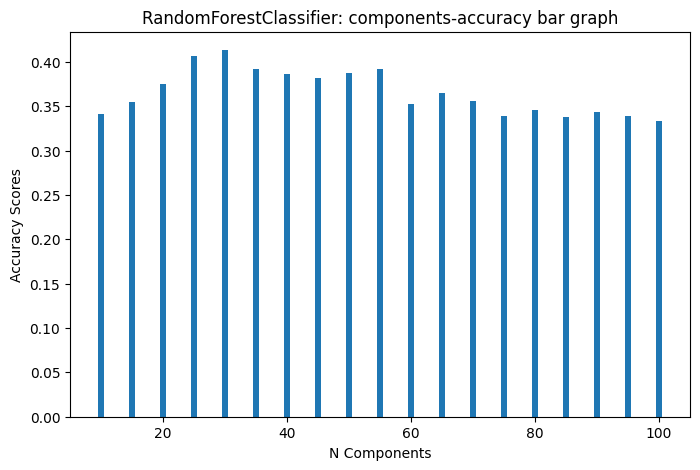

In [4]:
"""
class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
"""
RF_clf = RandomForestClassifier(n_estimators=80, max_depth=10)
RF_results = face_classifier.run(RF_clf)
face_classifier.plot_results(RF_results, 'RandomForestClassifier')

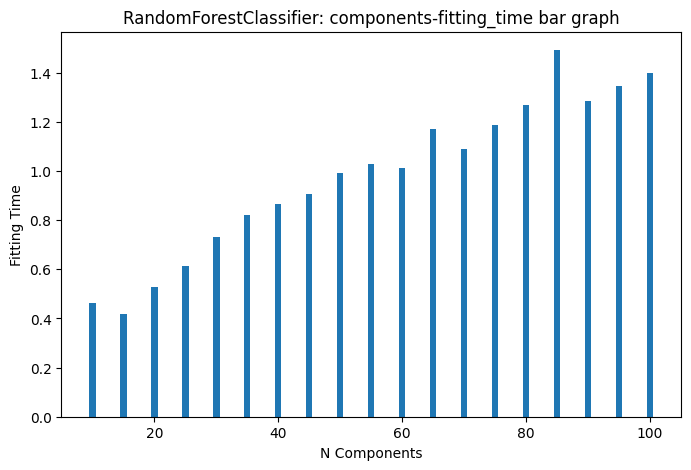

In [5]:
face_classifier.plot_results(RF_results, 'RandomForestClassifier', 'fitting_time')

#### BaggingClassifier

==========  1 Iteration ==========
Extracting the top 10 eigenfaces from 1896 faces
Algorithm fitting done in 0.048s
Accuracy Score: 0.3059071729957806
==========  2 Iteration ==========
Extracting the top 15 eigenfaces from 1896 faces
Algorithm fitting done in 0.049s
Accuracy Score: 0.3080168776371308
==========  3 Iteration ==========
Extracting the top 20 eigenfaces from 1896 faces
Algorithm fitting done in 0.047s
Accuracy Score: 0.3987341772151899
==========  4 Iteration ==========
Extracting the top 25 eigenfaces from 1896 faces
Algorithm fitting done in 0.053s
Accuracy Score: 0.43037974683544306
==========  5 Iteration ==========
Extracting the top 30 eigenfaces from 1896 faces
Algorithm fitting done in 0.065s
Accuracy Score: 0.45358649789029537
==========  6 Iteration ==========
Extracting the top 35 eigenfaces from 1896 faces
Algorithm fitting done in 0.025s
Accuracy Score: 0.45569620253164556
==========  7 Iteration ==========
Extracting the top 40 eigenfaces from 1896 faces
A

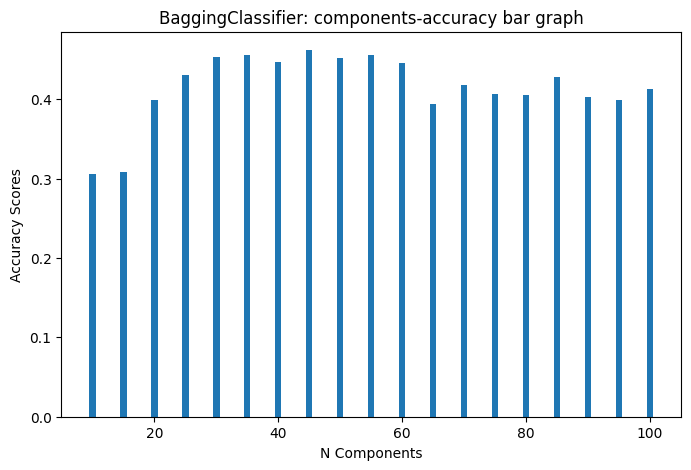

In [6]:
"""
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
"""
Bagging_clf = BaggingClassifier(KNeighborsClassifier(), n_estimators=20, max_samples=0.5, max_features=0.5)
BC_results = face_classifier.run(Bagging_clf)
face_classifier.plot_results(BC_results, 'BaggingClassifier')

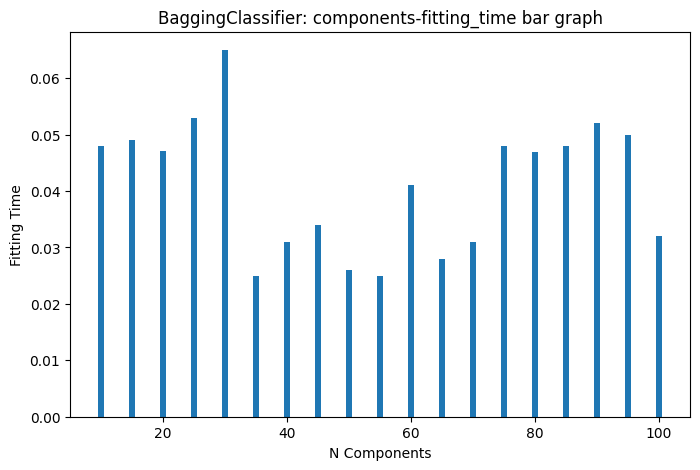

In [7]:
face_classifier.plot_results(BC_results, 'BaggingClassifier', 'fitting_time')

#### VotingClassifier

Weak classifier training time (all of three): 4331.576102972031
==========  1 Iteration ==========
Extracting the top 10 eigenfaces from 1896 faces
Algorithm fitting done in 1.831s
Accuracy Score: 0.43248945147679324
==========  2 Iteration ==========
Extracting the top 15 eigenfaces from 1896 faces
Algorithm fitting done in 2.044s
Accuracy Score: 0.4978902953586498
==========  3 Iteration ==========
Extracting the top 20 eigenfaces from 1896 faces
Algorithm fitting done in 2.121s
Accuracy Score: 0.5949367088607594
==========  4 Iteration ==========
Extracting the top 25 eigenfaces from 1896 faces
Algorithm fitting done in 2.344s
Accuracy Score: 0.6561181434599156
==========  5 Iteration ==========
Extracting the top 30 eigenfaces from 1896 faces
Algorithm fitting done in 2.656s
Accuracy Score: 0.6919831223628692
==========  6 Iteration ==========
Extracting the top 35 eigenfaces from 1896 faces
Algorithm fitting done in 2.466s
Accuracy Score: 0.7067510548523207
==========  7 Iteration

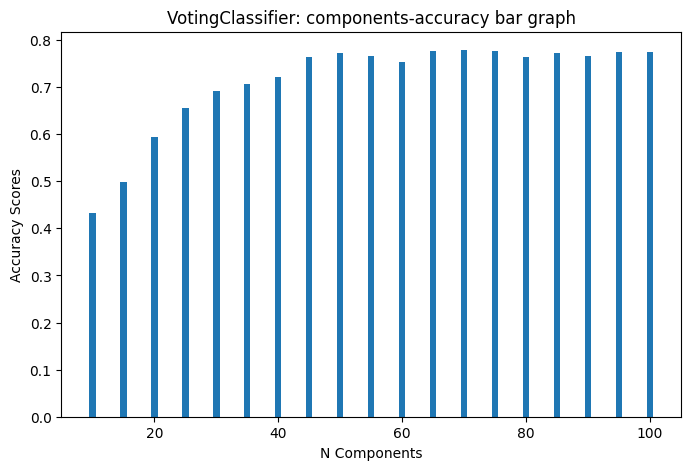

In [8]:
"""
class sklearn.ensemble.VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)
"""
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
Voting_clf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1,1,5])

# Pretrain weak classifier
n_samples, height, width = face_classifier.face_features.shape
X = face_classifier.face_features.copy().reshape((n_samples, height*width))
y = face_classifier.face_labels
weak_clf_train_start = time()
clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
single_algorithm_fitting_time = time() - weak_clf_train_start
print(f"Weak classifier training time (all of three): {single_algorithm_fitting_time}")

# Train voting algorithm
VC_results = face_classifier.run(Voting_clf)
face_classifier.plot_results(VC_results, 'VotingClassifier')

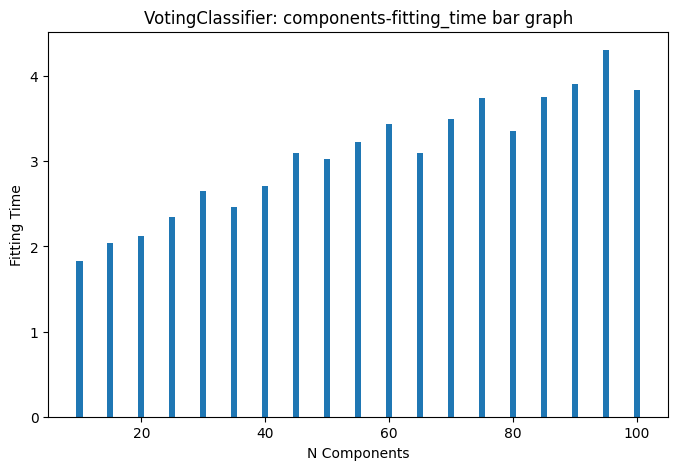

In [9]:
face_classifier.plot_results(VC_results, 'VotingClassifier', 'fitting_time')

#### BoostingClassifier

==========  1 Iteration ==========
Extracting the top 10 eigenfaces from 1896 faces
Algorithm fitting done in 30.923s
Accuracy Score: 0.3206751054852321
==========  2 Iteration ==========
Extracting the top 15 eigenfaces from 1896 faces
Algorithm fitting done in 42.447s
Accuracy Score: 0.3080168776371308
==========  3 Iteration ==========
Extracting the top 20 eigenfaces from 1896 faces
Algorithm fitting done in 52.265s
Accuracy Score: 0.33544303797468356
==========  4 Iteration ==========
Extracting the top 25 eigenfaces from 1896 faces
Algorithm fitting done in 62.713s
Accuracy Score: 0.35443037974683544
==========  5 Iteration ==========
Extracting the top 30 eigenfaces from 1896 faces
Algorithm fitting done in 73.733s
Accuracy Score: 0.350210970464135
==========  6 Iteration ==========
Extracting the top 35 eigenfaces from 1896 faces
Algorithm fitting done in 85.171s
Accuracy Score: 0.3628691983122363
==========  7 Iteration ==========
Extracting the top 40 eigenfaces from 1896 fac

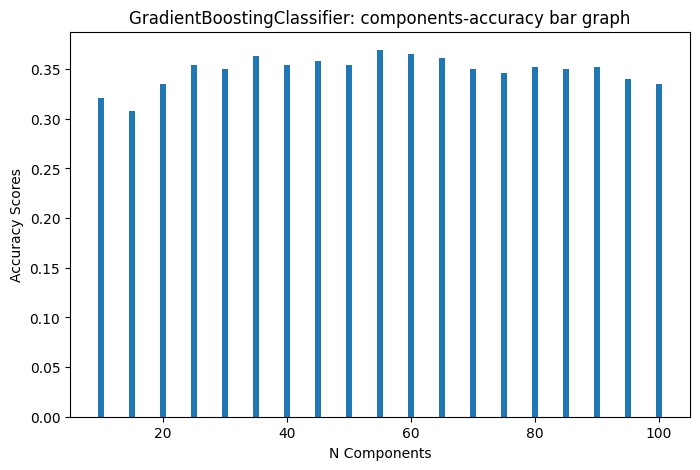

In [10]:
"""
class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
"""
Boosting_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.01, max_depth=3, random_state=0)
GBC_results = face_classifier.run(Boosting_clf)
face_classifier.plot_results(GBC_results, 'GradientBoostingClassifier')

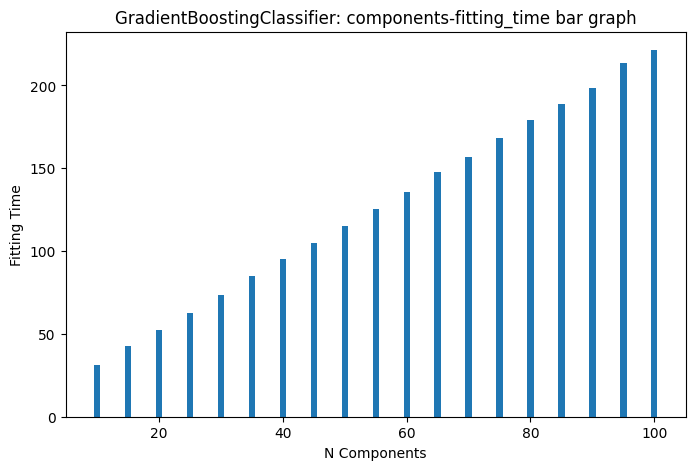

In [11]:
face_classifier.plot_results(GBC_results, 'GradientBoostingClassifier', 'fitting_time')

#### Support Vector Machine

==========  1 Iteration ==========
Extracting the top 10 eigenfaces from 1896 faces
Algorithm fitting done in 0.222s
Accuracy Score: 0.41561181434599154
==========  2 Iteration ==========
Extracting the top 15 eigenfaces from 1896 faces
Algorithm fitting done in 0.308s
Accuracy Score: 0.47257383966244726
==========  3 Iteration ==========
Extracting the top 20 eigenfaces from 1896 faces
Algorithm fitting done in 0.310s
Accuracy Score: 0.5421940928270043
==========  4 Iteration ==========
Extracting the top 25 eigenfaces from 1896 faces
Algorithm fitting done in 0.345s
Accuracy Score: 0.6012658227848101
==========  5 Iteration ==========
Extracting the top 30 eigenfaces from 1896 faces
Algorithm fitting done in 0.400s
Accuracy Score: 0.6434599156118144
==========  6 Iteration ==========
Extracting the top 35 eigenfaces from 1896 faces
Algorithm fitting done in 0.405s
Accuracy Score: 0.6455696202531646
==========  7 Iteration ==========
Extracting the top 40 eigenfaces from 1896 faces
Al

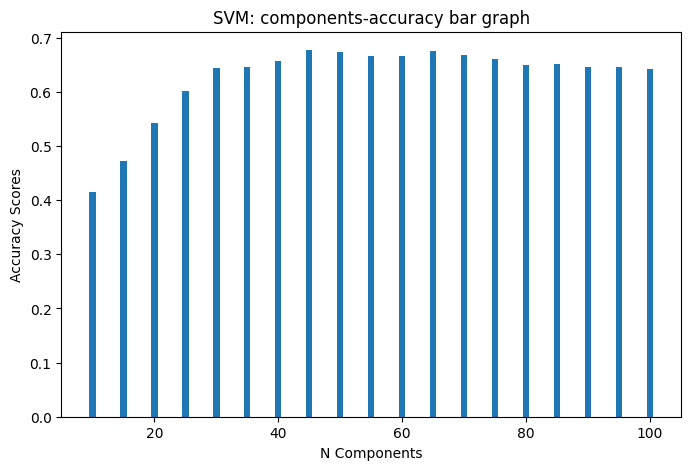

In [12]:
SVC_clf = SVC()
SVC_results = face_classifier.run(SVC_clf)
face_classifier.plot_results(SVC_results, 'SVM')

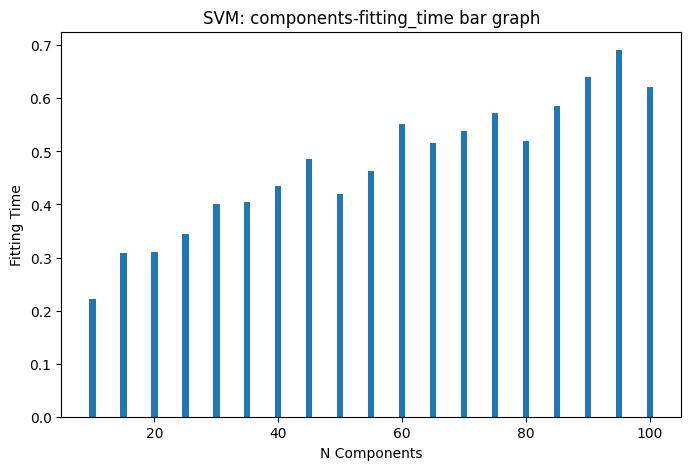

In [13]:
face_classifier.plot_results(SVC_results, 'SVM', 'fitting_time')

### Visualization of experimental results

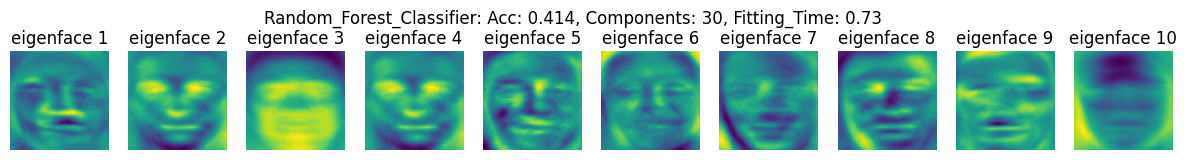

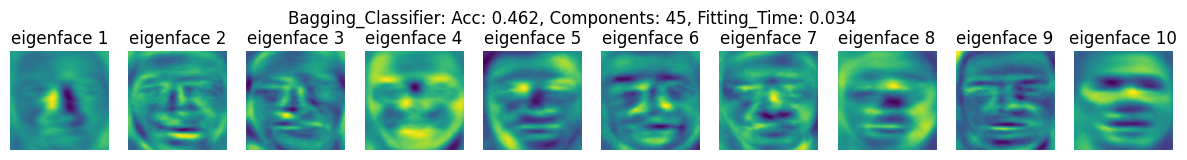

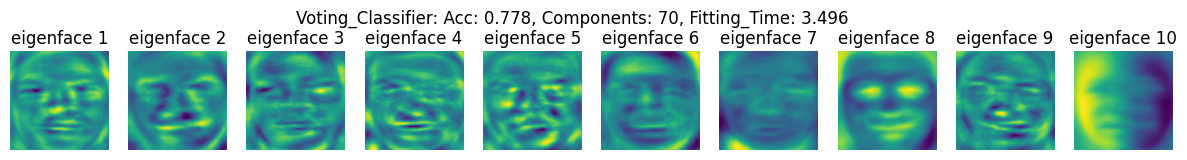

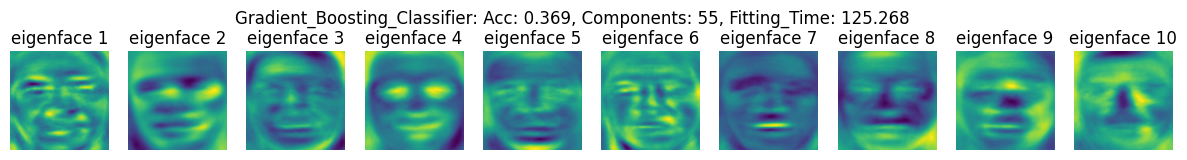

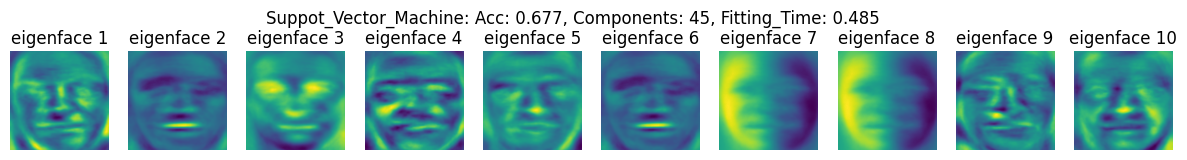

In [14]:
best_collections = extract_best_results(Random_Forest_Classifier=RF_results,
                                        Bagging_Classifier=BC_results,
                                        Voting_Classifier=VC_results,
                                        Gradient_Boosting_Classifier=GBC_results,
                                        Suppot_Vector_Machine=SVC_results)

In [15]:
collection_df = pd.DataFrame(best_collections)
collection_df

,Random_Forest_Classifier,Bagging_Classifier,Voting_Classifier,Gradient_Boosting_Classifier,Suppot_Vector_Machine
best_accuracy,0.414,0.462,0.778,0.369,0.677
fitting_time,0.730,0.034,3.496,125.268,0.485
best_components,30.000,45.000,70.000,55.000,45.000


### Save the best ML algorithms

In [16]:
# Best Voting classifier
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
Voting_clf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1,1,5])

# Pretrain weak classifier
n_samples, height, width = face_classifier.face_features.shape
X = face_classifier.face_features.copy().reshape((n_samples, height*width))
y = face_classifier.face_labels
clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
ensemble_algorithm_results = face_classifier.fit_one_model(Voting_clf, 
                                                           pca_components=70, 
                                                           pca_file=os.path.join(save_dir, 'PCA.pkl'), 
                                                           model_file=os.path.join(save_dir, 'Voting_Classifier.pkl'))

Extracting the top 70 eigenfaces from 1896 faces
PCA fitting done in 11.504s
Accuracy Score: 0.7763713080168776
Save PCA algorithm at ./Ensemble_algorithm\PCA.pkl
Save ML algorithm at ./Ensemble_algorithm\Voting_Classifier.pkl


In [17]:
ensemble_algorithm_results

{'Accuracy': 0.7763713080168776,
 'Precision': 0.8017907212376074,
 'Recall': 0.7763713080168776,
 'f1_score': 0.7741560463098639}

In [18]:
None

## Create dataset for testing

In [19]:
data_home = "./lfw_dataset"

# Pairs dataset
train_pairs, test_pairs = load_dataset(data_home=data_home, pairs=True)

# All faces dataset
dataset = load_dataset(data_home=data_home, pairs=False)

In [20]:
dataset.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [21]:
names = dataset["target_names"]

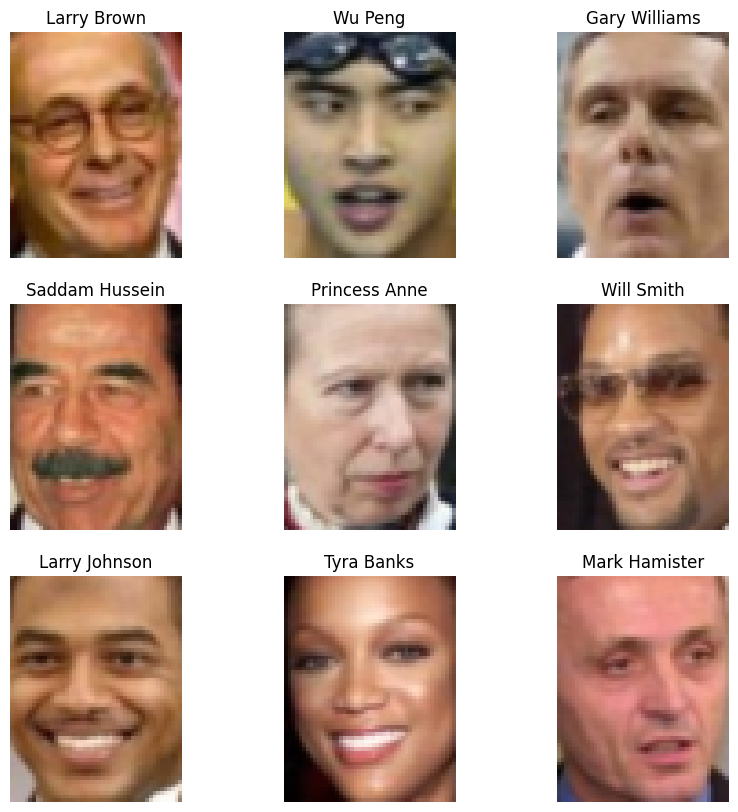

In [22]:
# show the images from LFW dataset
plt.figure(figsize=(10, 10))
nrows = 3
ncols = 3
all_classes = len(dataset["data"])

for i in range( nrows * ncols ):
    plt.subplot(nrows, ncols, i+1)
    index = random.randint(0, all_classes-1)
    plt.imshow(dataset["images"][index]/255.)
    plt.axis('off')
    plt.title(names[dataset["target"][index]], fontsize=12)
plt.show()

In [23]:
train_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [24]:
target_names = train_pairs["target_names"]

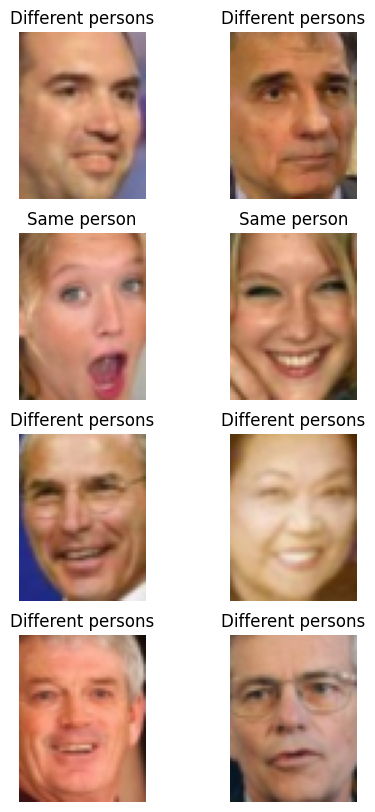

In [25]:
# show the pair images from LFW dataset
fig, axs = plt.subplots(4, 2, figsize=(5, 10))
all_pairs = len(train_pairs["pairs"])

for i in range(4):
    index = random.randint(0, all_pairs-1)
    title = target_names[train_pairs["target"][index]]
    img1 = train_pairs["pairs"][index][0]/255.
    img2 = train_pairs["pairs"][index][1]/255.
    axs[i, 0].imshow(img1)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(title)
    axs[i, 1].imshow(img2)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(title)
plt.show()

In [26]:
# define training dataset
train_data = train_pairs["pairs"]
train_labels = train_pairs["target"]
train_label_names = train_pairs["target_names"]

In [27]:
# define testing dataset
test_data = test_pairs["pairs"]
test_labels = test_pairs["target"]
test_label_names = test_pairs["target_names"]

## Load pre-train algorithm: FaceNet model

<u>**FaceNet backbone**</u>

[MobileNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet): Models of MobileNet-series are lightweight neural network using **Depthwise Separable Convolutional filter** technique containing **depthwise convolution** and **pointwise convolution** to extremely decrease of parameter calculation.

**Depth-wise convolution**

The depth-wise convolutions are used to apply a single filter into each input channel. This is different from a standard convolution in which the filters are applied to all of the input channels.

**Point-wise Convolution**

Since the depthwise convolution is only used to filter the input channel, it does not combine them to produce new features. So an additional layer called pointwise convolution layer is made, which computes a linear combination of the output of depthwise convolution using a 1 × 1 convolution.


Information credit: [1](https://github.com/Leohoji/End-to-end-Multil-Class-Cat-Breed-Classification-Reaches-93-Percent-Accuracy/blob/main/End-to-end%20Multil-Class%20Cat-Breed%20Classification%20Reaches%2093%25%20Accuracy.ipynb)、[2](https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d)


After deep architecture, there are two options:

1. If you would like to use pre-train model to **train** on your datasets, you need to add: (1) fully-connected layers and softmax layer as Auxiliary classifier (explain later); (2) normalized layer to calculate L2 distance for output embedding.

2. If tou wold like to use pre-train model to **predict** on your datasets only, you just add normalized layer.

In [28]:
# Set input shape
INPUT_SHAPE = [160, 160, 3]

# Set path of model weights
model_path = 'model_data/facenet_mobilenet.h5'

# Load model architecture and weights
model = FaceNet(input_shape=INPUT_SHAPE, mode='predict')
model.load_weights(model_path, by_name=True)

# Check model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                                      

In [29]:
# tf.keras.utils.plot_model(model, to_file='./results/FaceNet.png', show_shapes=True, show_dtype=True, show_layer_names=True)

**Detect an image**

In [30]:
# choose images
index = random.randint(0, len(train_pairs))
images = train_data[index]
image_1, image_2 = images[0], images[1]

# set label
label_index = train_labels[index]
label = train_label_names[label_index]

# calculate distance between embeddings
l2_value, (img1, img2) = detect_image(image_1, image_2, model=model, input_shape=INPUT_SHAPE)
print(f"output value: {'Same person' if l2_value <= 1.0 else 'Different Person'}")
print(f"y_true is {label}")

output value: Same person
y_true is Same person


2024-08-16 11:13:48,622 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


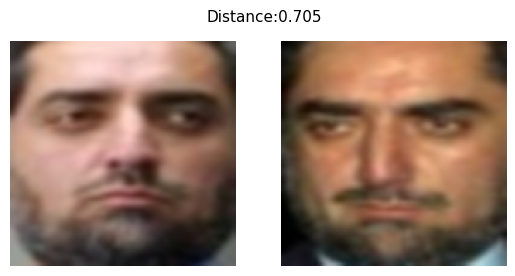

In [31]:
plt.figure()
for i, img in enumerate([img1[0], img2[0]]):
    plt.subplot(1, 2, i+1)
    img = np.where(img < 0, 0, img)
    plt.imshow(np.array(img))
    plt.axis('off')
plt.text(-12, -12, 'Distance:%.3f' % l2_value, ha='center', va='bottom', fontsize=11)
plt.show()

#### Model testing for face verification

Apply SVM for classification: Training a SVM classifier to separate two vectors from model output

In [32]:
# train_label_names
X_train = []
y_train = train_labels

print('Create training data for helper algorithm for face verification.')
for imgs in tqdm(train_data):
    img1, img2 = imgs[0], imgs[1]
    dists, (_, _) = detect_image(img1, img2, model=model, input_shape=INPUT_SHAPE)
    X_train.append(dists)

# Create X and y in model acceptable format
X = np.array(X_train).reshape(-1, 1)
y = y_train

# fit the model
svm_clf =  LinearSVC(random_state=42, tol=1e-4, max_iter=10000)
svm_clf.fit(X, y)
print(svm_clf)

# model prediction for training score
train_preds = svm_clf.predict(X)
original_facenet_train_results = model_evaluation(y, train_preds)
print(f"Evaluation on training data: {original_facenet_train_results}") 

# Testing data
X_test = []
y_test = test_labels

print('Create testing data for helper algorithm for face verification.')
for imgs in tqdm(test_data):
    img1, img2 = imgs[0], imgs[1]
    dists, (_, _) = detect_image(img1, img2, model=model, input_shape=INPUT_SHAPE)
    X_test.append(dists)

# model prediction for testing score
X_test = np.array(X_test).reshape(-1, 1)
test_preds = svm_clf.predict(X_test)

original_facenet_test_results = model_evaluation(y_test, test_preds)
print(f"Evaluation on testing data: {original_facenet_test_results}")

Create training data for helper algorithm for face verification.


100%|██████████████████████████████████████████████████████████████████████████████| 2200/2200 [05:39<00:00,  6.47it/s]


LinearSVC(max_iter=10000, random_state=42)
Evaluation on training data: {'Accuracy': 0.96, 'Precision': 0.9600060827250608, 'Recall': 0.96, 'f1_score': 0.9599998677681579}
Create testing data for helper algorithm for face verification.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.09it/s]

Evaluation on testing data: {'Accuracy': 0.947, 'Precision': 0.9470876291753184, 'Recall': 0.947, 'f1_score': 0.9469974028727408}


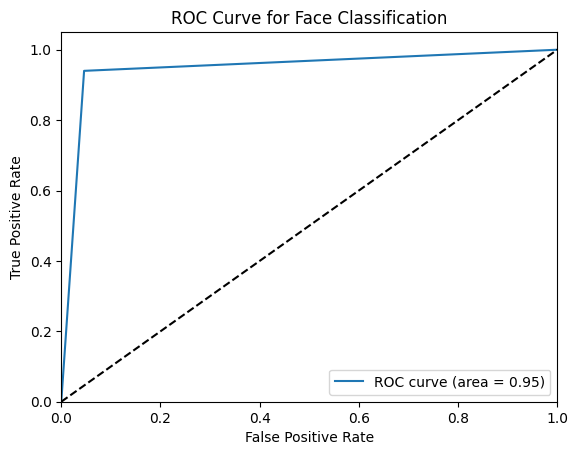

In [33]:
figure_name = './FaceNet_results/FaceNet_model_ROC_AUC_curve.jpg'
plot_roc_auc_curve(y_test, test_preds, save_name=figure_name)

## Start Expeirments !!!

In [34]:
from Utils.model_utils import FaceNetExperiment
from Utils.model_utils import plot_facenet_training_history, plot_cluster_facenet_training_history

In [35]:
def preprocess_for_quantization_float(path):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image_rgb, [160, 160], interpolation=cv2.INTER_CUBIC) / 255.
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
        
    return image 

In [36]:
def process_image_for_quantization_int(image_path:str, target_size:list=INPUT_SHAPE) -> tf.Tensor:
    """
    Process images that acceptable for quantization transformation in integer data typpe.

    Args:
        image_path: Image path for preprocessing.
        target_size: A list for image size representation.
    Returns:
        Processed image object in tensor data typpe.
    """
    img = cv2.imread(image_path) # read image
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB
    img = cv2.resize(img, [target_size[1], target_size[0]]) # resize imagee
    img = img.astype(np.float32) / 255.0 # normalization
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32) # convert to Tensor
    
    return img_tensor

### Re-train the pre-train model with hyperparameter tuning

In [37]:
# train
annotation_path  = "cls_train.txt"
input_shape      = [160, 160, 3]
model_path       = "model_data/facenet_mobilenet.h5"
Init_Epoch       = 0
Epoch            = 30
batch_size       = 24
Init_lr          = 1e-2
optimizer_type   = "adam"
lr_decay_type    = "cos"

facenet_expeirment = FaceNetExperiment(annotation_path=annotation_path, 
                                       input_shape=input_shape, 
                                       model_path=model_path, 
                                       init_epoch=Init_Epoch, 
                                       pre_train_model=None, 
                                       epoch=Epoch, 
                                       batch_size=batch_size, 
                                       optimizer_type=optimizer_type, 
                                       init_lr=Init_lr)

Number of classes: 34
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|              num_classes |                                       34|
|               model_path |          model_data/facenet_mobilenet.h5|
|              input_shape |                            [160, 160, 3]|
|                optimizer |                                     adam|
|        learning_rate_fit |                                    0.001|
|      learning_rate_decay |                                      cos|
|               Init_Epoch |                                        0|
|                    Epoch |                                       30|
|               batch_size |                                       24|
|                num_train |                                     2133|
|                  num_val |           

In [38]:
loss_names=['Embedding', 'Softmax']
facenet_model_hitory =  facenet_expeirment.train(loss_names=loss_names)

Train on 2133 samples, val on 237 samples, with batch size 24.

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/30
88/88 [==============================] - 18s 143ms/step - loss: 3.5292 - Softmax_loss: 3.4376 - Embedding_loss: 0.0916 - Softmax_categorical_accuracy: 0.1222 - val_loss: 2.6372 - val_Softmax_loss: 2.6169 - val_Embedding_loss: 0.0203 - val_Softmax_categorical_accuracy: 0.2361 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999999999998.
Epoch 2/30
88/88 [==============================] - 12s 130ms/step - loss: 1.9610 - Softmax_loss: 1.8787 - Embedding_loss: 0.0823 - Softmax_categorical_accuracy: 0.5194 - val_loss: 1.1862 - val_Softmax_loss: 1.1697 - val_Embedding_loss: 0.0165 - val_Softmax_categorical_accuracy: 0.7870 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/30
88/88 [==============================] - 12s 130ms/step - loss: 0.7103 - Softmax_loss: 0.6478 - Embedding_l

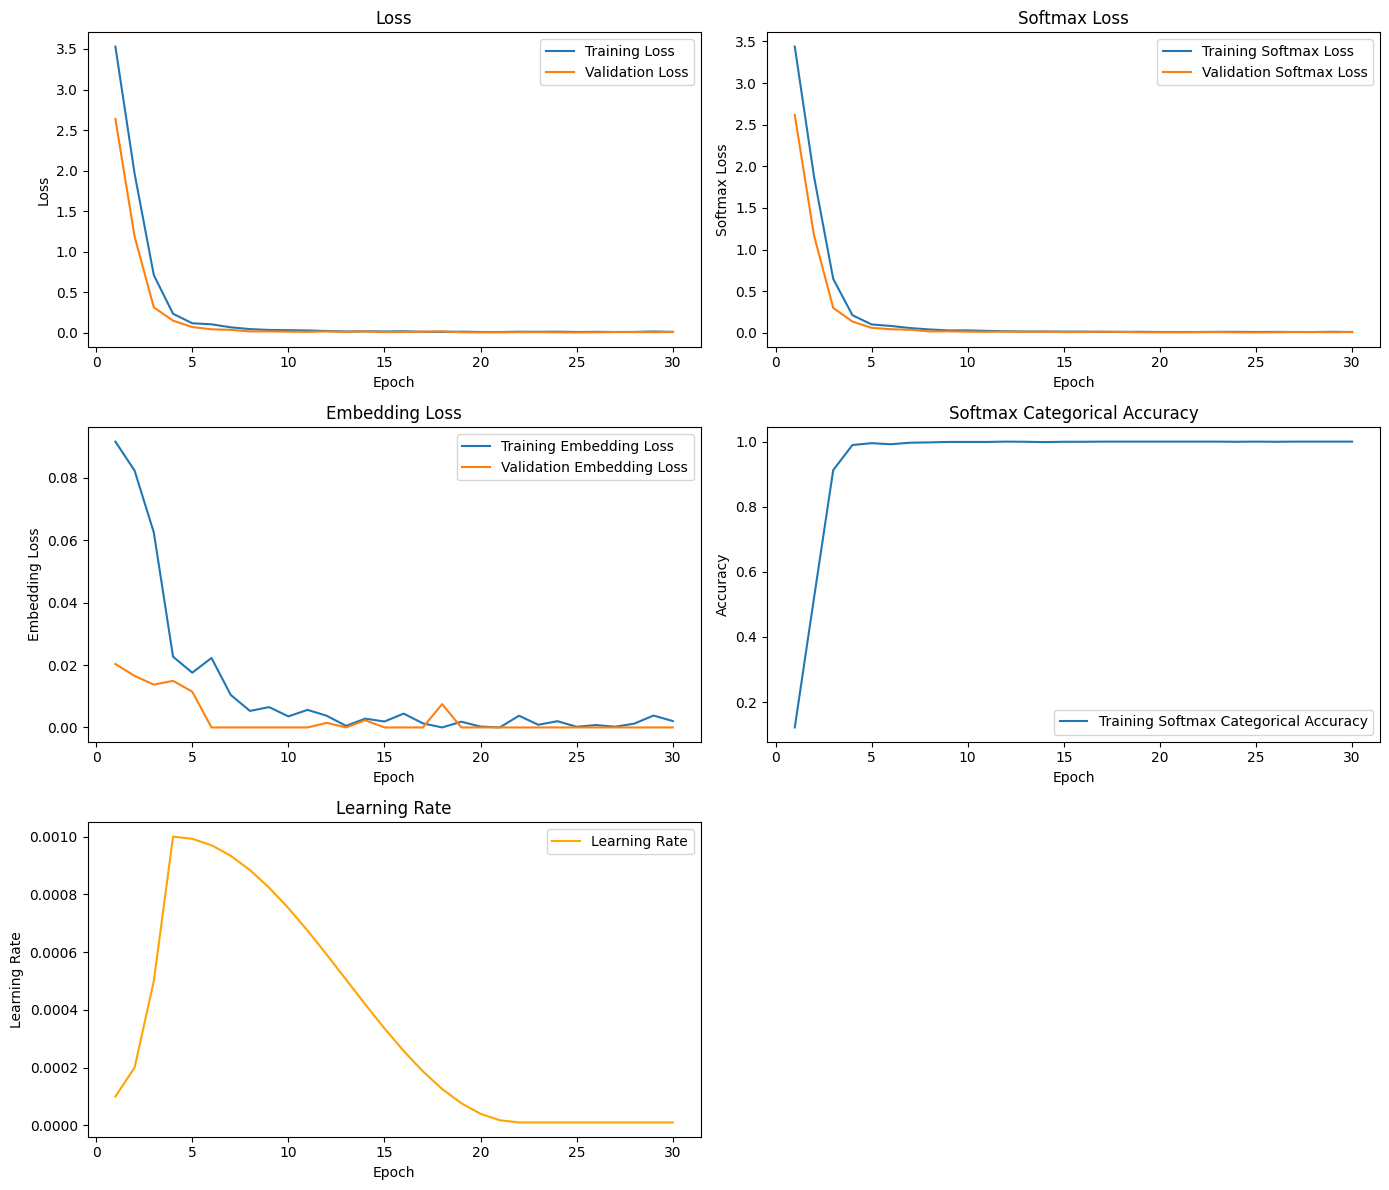

In [39]:
plot_facenet_training_history(facenet_model_hitory.history)

In [40]:
facenet_expeirment.model.output

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'Softmax')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Embedding')>]

In [41]:
facenet_expeirment.save_model('./model_data/facenet_mobilenet_fine_tune_weights.h5', 
                              './model_data/facenet_mobilenet_classifier.h5')

Model has been saved as ./model_data/facenet_mobilenet_fine_tune_weights.h5 and ./model_data/facenet_mobilenet_classifier.h5


#### Model testing for face verification

Apply SVM for classification: Training a SVM classifier to separate two vectors from model output

In [42]:
# load model
feaExtPath = './model_data/facenet_mobilenet_fine_tune_weights.h5'
feature_extractor = FaceNet(input_shape=INPUT_SHAPE, num_classes=facenet_expeirment.num_classes, mode="predict")
if feaExtPath != '':
    feature_extractor.load_weights(feaExtPath, by_name=True, skip_mismatch=True)

feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                                    

In [43]:
# train_label_names
X_train = []
y_train = train_labels

print('Create training data for helper algorithm for face verification.')
for imgs in tqdm(train_data):
    img1, img2 = imgs[0], imgs[1]
    dists, (_, _) = detect_image(img1, img2, model=feature_extractor, input_shape=INPUT_SHAPE)
    X_train.append(dists)

# Create X and y in model acceptable format
X = np.array(X_train).reshape(-1, 1)
y = y_train

# fit the model
svm_clf =  LinearSVC(random_state=42, tol=1e-4, max_iter=10000)
svm_clf.fit(X, y)
print(svm_clf)

# model prediction for training score
train_preds = svm_clf.predict(X)
facenet_fine_tune_verification_train_results = model_evaluation(y, train_preds)
print(f"Evaluation on training data: {facenet_fine_tune_verification_train_results}") 

# Testing data
X_test = []
y_test = test_labels

print('Create testing data for helper algorithm for face verification.')
for imgs in tqdm(test_data):
    img1, img2 = imgs[0], imgs[1]
    dists, (_, _) = detect_image(img1, img2, model=feature_extractor, input_shape=INPUT_SHAPE)
    X_test.append(dists)

# model prediction for testing score
X_test = np.array(X_test).reshape(-1, 1)
test_preds = svm_clf.predict(X_test)

facenet_fine_tune_verification_test_results = model_evaluation(y_test, test_preds)
print(f"Evaluation on testing data: {facenet_fine_tune_verification_test_results}")

Create training data for helper algorithm for face verification.


100%|██████████████████████████████████████████████████████████████████████████████| 2200/2200 [05:58<00:00,  6.14it/s]


LinearSVC(max_iter=10000, random_state=42)
Evaluation on training data: {'Accuracy': 0.9186363636363636, 'Precision': 0.9188194673539093, 'Recall': 0.9186363636363636, 'f1_score': 0.9186274698205652}
Create testing data for helper algorithm for face verification.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.01it/s]

Evaluation on testing data: {'Accuracy': 0.922, 'Precision': 0.9220270097286226, 'Recall': 0.922, 'f1_score': 0.9219987519800317}


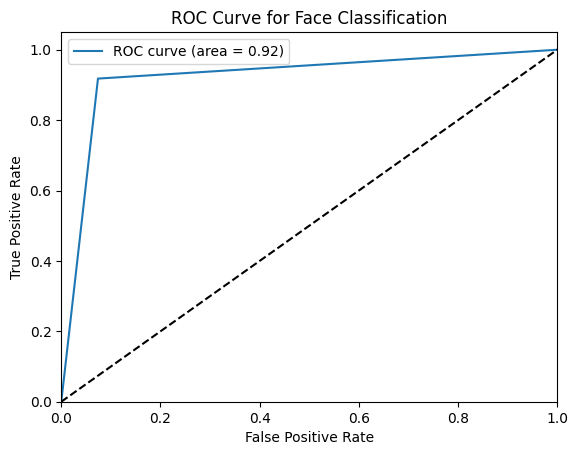

In [44]:
figure_name = './FaceNet_results/FaceNet_Fine_Tune_model_ROC_AUC_curve.jpg'
plot_roc_auc_curve(y_test, test_preds, save_name=figure_name)

#### Model testing for face recognition

In [45]:
val_paths = facenet_expeirment.val_dataset.paths.copy()
val_labels = facenet_expeirment.val_dataset.labels.copy()

In [46]:
INPUT_SHAPE = facenet_expeirment.input_shape
facenet_model = facenet_expeirment.model

In [47]:
val_preds = []
for path in tqdm(val_paths):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    class_result = classify_image(image_rgb, model=facenet_model, input_shape=INPUT_SHAPE)
    val_preds.append(class_result)

val_preds = np.array(val_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:21<00:00, 11.04it/s]


In [48]:
facenet_fine_tune_recognition_results = model_evaluation(val_labels, val_preds)
facenet_fine_tune_recognition_results

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'f1_score': 1.0}

### post-training with float16 quantization

In this step, I will convert a trained model with float32 default into a tflite model with float16.

Transformation steps are following:

1. Load pre-train model

2. Convert float32 model to the tflite model

3. Quantize a float32 model into float16 model, and convert it to the tflite model

4. Test the quantized model and evaluate the model with compression rate and accuracy scores

Source_code: [Post-training float16 quantization](https://www.tensorflow.org/lite/performance/post_training_float16_quant)

#### Load pre-train model

In [49]:
facenet_classifier_path = './model_data/facenet_mobilenet_classifier.h5'
model_loaded = tf.keras.models.load_model(facenet_classifier_path, 
                                          custom_objects={'_triplet_loss': triplet_loss, 'relu6': relu6})

model_loaded.output

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'Softmax')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Embedding')>]

#### Convert and save pre-tain model to a TensorFlow Lite model

In [50]:
# Convert to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
tflite_model = converter.convert()

2024-08-16 11:37:27,098 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 27). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwzza9jcd\assets


2024-08-16 11:37:30,611 Assets written to: C:\Users\User\AppData\Local\Temp\tmpwzza9jcd\assets


In [51]:
# Create tflite model path
tflite_models_dir = Path("./tmp/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [52]:
# Write model into path
tflite_model_file = tflite_models_dir/"tflite_unquantized_model_F.tflite"
tflite_model_f32_size = tflite_model_file.write_bytes(tflite_model)
tflite_model_f32_size

13867052

#### Quantize a float32 model into float16 model, and convert it to the tflite model

In [53]:
# Set target quantization data type of model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [54]:
# Convert model into float16 tflite model
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"tflite_quantized_model_foat16.tflite"
tflite_model_fp16_size = tflite_model_fp16_file.write_bytes(tflite_fp16_model)
tflite_model_fp16_size

2024-08-16 11:37:48,916 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 27). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpd282fb55\assets


2024-08-16 11:37:52,430 Assets written to: C:\Users\User\AppData\Local\Temp\tmpd282fb55\assets


6950240

In [55]:
interpreter_fp32 = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter_fp32.allocate_tensors()

In [56]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [57]:
interpreter_fp16.get_input_details()

[{'name': 'serving_default_input_2:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3]),
  'shape_signature': array([ -1, 160, 160,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [58]:
interpreter_fp16.get_input_details()

[{'name': 'serving_default_input_2:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3]),
  'shape_signature': array([ -1, 160, 160,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

#### Test the models

In [59]:
# Test the models
tf32_preds = []

input_index = interpreter_fp32.get_input_details()[0]["index"]
output_index = interpreter_fp32.get_output_details()[0]["index"]

for path in tqdm(val_paths):
    image = preprocess_for_quantization_float(path)
    interpreter_fp32.set_tensor(input_index, image)
    interpreter_fp32.invoke()
    prediction = interpreter_fp32.get_tensor(output_index)
    class_result = np.argmax(prediction)
    
    tf32_preds.append(class_result)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:05<00:00, 40.66it/s]


In [60]:
facenet_unquantization_float_results = model_evaluation(val_labels, tf32_preds)
facenet_unquantization_float_results

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'f1_score': 1.0}

In [61]:
# Test the models
tf16_preds = []

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

for path in tqdm(val_paths):
    image = preprocess_for_quantization_float(path)
    interpreter_fp16.set_tensor(input_index, image)
    interpreter_fp16.invoke()
    prediction = interpreter_fp16.get_tensor(output_index)
    class_result = np.argmax(prediction)
    
    tf16_preds.append(class_result)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:04<00:00, 48.58it/s]


In [62]:
facenet_quantization_float_results = model_evaluation(val_labels, tf16_preds)
facenet_quantization_float_results

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'f1_score': 1.0}

In [63]:
float_compression_rate = round((tflite_model_fp16_size / tflite_model_f32_size) * 100, 3)
print('Compression rate of float16 quantization: {}'.format(float_compression_rate))

Compression rate of float16 quantization: 50.121


### post-training with int quantization

In this step, I will convert a trained model with float32 default into a tflite model with int.

Transformation steps are following:

1. Load pre-train model and prepare dataset

2. Convert float32 model to the tflite model

3. Quantize a float32 model into int model, and convert it to the tflite model

4. Test the quantized model and evaluate the model with compression rate and accuracy scores

📖 **Notes**: To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a RepresentativeDataset. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

Source_code: [Post-training integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant)

#### Load pre-train model

In [64]:
facenet_classifier_path = './model_data/facenet_mobilenet_classifier.h5'
INT_facenet_model_loaded = tf.keras.models.load_model(facenet_classifier_path, 
                                                      custom_objects={'_triplet_loss': triplet_loss, 'relu6': relu6})

INT_facenet_model_loaded.output

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'Softmax')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Embedding')>]

#### Prepare the representative data

In [65]:
INPUT_SHAPE

[160, 160, 3]

In [66]:
train_images = facenet_expeirment.train_dataset.paths.copy()

In [67]:
train_tensors = [process_image_for_quantization_int(path) for path in train_images]

In [68]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_tensors).batch(1).take(100):
    yield [input_value]

#### Convert and save pre-tain model to a TensorFlow Lite model

In [69]:
converter = tf.lite.TFLiteConverter.from_keras_model(INT_facenet_model_loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int_model = converter.convert()

2024-08-16 11:38:33,241 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 27). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmprtitx_2q\assets


2024-08-16 11:38:36,351 Assets written to: C:\Users\User\AppData\Local\Temp\tmprtitx_2q\assets
C:\Users\User\miniconda3\envs\faceNet\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [70]:
interpreter = tf.lite.Interpreter(model_content=tflite_int_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [71]:
tflite_models_dir = Path("./tmp/tflite_models/")

if not Path.is_dir(tflite_models_dir):
    tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [72]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"tflite_unquantized_model_I.tflite"
tflite_model_f32_size_2 = tflite_model_file.write_bytes(tflite_model)
tflite_model_f32_size_2

13867052

In [74]:
# Save the quantized model:
tflite_model_int_file = tflite_models_dir/"tflite_quantized_model_int.tflite"
tflite_model_int_size = tflite_model_int_file.write_bytes(tflite_int_model)
tflite_model_int_size

3778160

#### Test the models

In [75]:
# Prepare test data
test_images = facenet_expeirment.val_dataset.paths.copy()
test_tensors = [process_image_for_quantization_int(path) for path in test_images]
test_labels = facenet_expeirment.val_dataset.labels.copy()

In [76]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_tensors
    
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(tqdm(test_image_indices)):
        test_image = test_tensors[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
          input_scale, input_zero_point = input_details["quantization"]
          test_image = test_image / input_scale + input_zero_point
    
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
    
        predictions[i] = output.argmax()

    return predictions

In [77]:
# unquantized model
test_image_indices = range(test_images.shape[0])
unquantized_predictions = run_tflite_model(tflite_model_file, test_image_indices)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:03<00:00, 70.51it/s]


In [78]:
facenet_unquantization_results = model_evaluation(test_labels, unquantized_predictions)
facenet_unquantization_results

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'f1_score': 1.0}

In [82]:
test_image_indices = range(test_images.shape[0])
quantized_predictions = run_tflite_model(tflite_model_int_file, test_image_indices)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [07:52<00:00,  1.99s/it]


In [83]:
facenet_quantization_int_results = model_evaluation(test_labels, quantized_predictions)
facenet_quantization_int_results

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'f1_score': 1.0}

In [84]:
int_compression_rate = round((tflite_model_int_size / tflite_model_f32_size_2) * 100, 3)
print('Compression rate of float16 quantization: {}'.format(int_compression_rate))

Compression rate of float16 quantization: 27.246


In [85]:
int_model_details = interpreter.get_tensor_details()

### weight-clusteriing

Steps are following:

1. Load pre-train model and prepare dataset

2. Cluster convolutional and fully-connected layers

3. Fine-tune the clustered model

4. Test the quantized model and evaluate the model with compression rate and accuracy scores

Source_code: [Weight clustering in Keras example](https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example)

#### Load pre-train model

In [86]:
facenet_classifier_path = './model_data/facenet_mobilenet_classifier.h5'
weight_cluster_model_loaded = tf.keras.models.load_model(facenet_classifier_path, 
                                                         custom_objects={'_triplet_loss': triplet_loss, 'relu6': relu6})

weight_cluster_model_loaded.output

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'Softmax')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Embedding')>]

#### Define a clustered model

In [87]:
# Define a clustered model
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

clustered_model = cluster_weights(weight_cluster_model_loaded, **clustering_params)

clustered_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 cluster_conv1 (ClusterWeights)  (None, 80, 80, 32)  1744        ['input_2[0][0]']                
                                                                                                  
 cluster_conv1_bn (ClusterWeigh  (None, 80, 80, 32)  128         ['cluster_conv1[0][0]']          
 ts)                                                                                              
                                                                                            

In [88]:
clustered_model.output

[<KerasTensor: shape=(None, 34) dtype=float32 (created by layer 'cluster_Softmax')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'cluster_Embedding')>]

In [89]:
cluster_weights = clustered_model.get_weights()

#### Re-train the cluster model

In [90]:
# train
annotation_path  = "cls_train.txt"
input_shape      = [160, 160, 3]
model_path       = ""
Init_Epoch       = 0
Epoch            = 30
batch_size       = 24
Init_lr          = 1e-2
optimizer_type   = "adam"
lr_decay_type    = "cos"

cluster_facenet_expeirment = FaceNetExperiment(annotation_path=annotation_path, 
                                               input_shape=input_shape, 
                                               model_path=model_path, 
                                               init_epoch=Init_Epoch, 
                                               pre_train_model=clustered_model, 
                                               epoch=Epoch, 
                                               batch_size=batch_size, 
                                               optimizer_type=optimizer_type, 
                                               init_lr=Init_lr, 
                                               cluster=True)

Number of classes: 34
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|              num_classes |                                       34|
|               model_path |                                         |
|              input_shape |                            [160, 160, 3]|
|                optimizer |                                     adam|
|        learning_rate_fit |                                    0.001|
|      learning_rate_decay |                                      cos|
|               Init_Epoch |                                        0|
|                    Epoch |                                       30|
|               batch_size |                                       24|
|                num_train |                                     2133|
|                  num_val |           

In [91]:
cluster_loss_names=['cluster_Embedding', 'cluster_Softmax']
clustered_facenet_model_hitory = cluster_facenet_expeirment.train(cluster_loss_names)

Train on 2133 samples, val on 237 samples, with batch size 24.

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/30
88/88 [==============================] - 29s 270ms/step - loss: 3.7282 - cluster_Softmax_loss: 3.5538 - cluster_Embedding_loss: 0.1744 - cluster_Softmax_categorical_accuracy: 0.0672 - val_loss: 3.5115 - val_cluster_Softmax_loss: 3.3405 - val_cluster_Embedding_loss: 0.1710 - val_cluster_Softmax_categorical_accuracy: 0.1019 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00019999999999999998.
Epoch 2/30
88/88 [==============================] - 21s 242ms/step - loss: 3.2999 - cluster_Softmax_loss: 3.1189 - cluster_Embedding_loss: 0.1810 - cluster_Softmax_categorical_accuracy: 0.1615 - val_loss: 2.5740 - val_cluster_Softmax_loss: 2.4324 - val_cluster_Embedding_loss: 0.1416 - val_cluster_Softmax_categorical_accuracy: 0.3102 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/30
88/88 [====

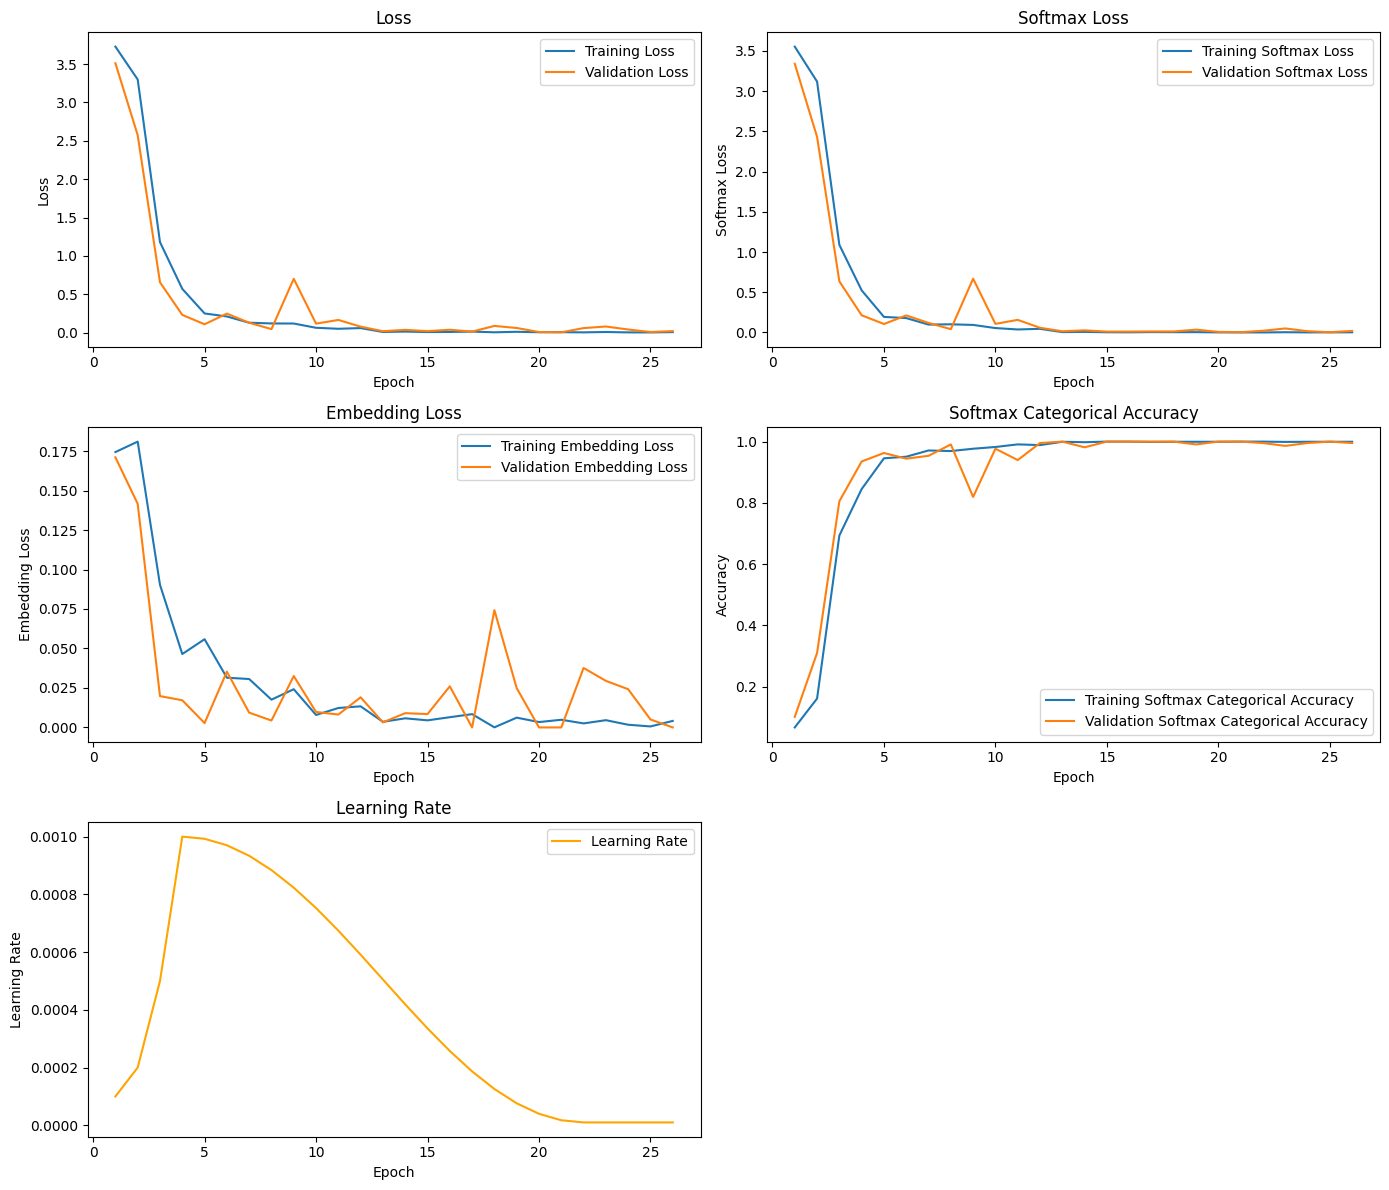

In [92]:
plot_cluster_facenet_training_history(clustered_facenet_model_hitory.history)

#### Test the cluster model

In [93]:
INPUT_SHAPE = cluster_facenet_expeirment.input_shape
val_paths = cluster_facenet_expeirment.val_dataset.paths.copy()
val_labels = cluster_facenet_expeirment.val_dataset.labels.copy()

In [94]:
val_preds = []
for path in tqdm(val_paths):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    class_result = classify_image(image_rgb, model=clustered_model, input_shape=INPUT_SHAPE)
    val_preds.append(class_result)

val_preds = np.array(val_preds)

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:23<00:00, 10.00it/s]


In [95]:
facenet_weight_clustering_results =  model_evaluation(val_labels, val_preds)
facenet_weight_clustering_results

{'Accuracy': 0.9957805907172996,
 'Precision': 0.9968354430379747,
 'Recall': 0.9957805907172996,
 'f1_score': 0.9959413301185454}

In [96]:
cluster_fine_tune_weights = clustered_model.get_weights()

#### Save the cluster model

There are two steps for cluster mdoel saving:

First, create a compressible model for TensorFlow. Here, `strip_clustering` removes all variables (e.g. `tf.Variable` for storing the cluster centroids and the indices) that clustering only needs during training, which would otherwise add to model size during inference.

Then, create compressible models for TFLite. You can convert the clustered model to a format that's runnable on your targeted backend. TensorFlow Lite is an example you can use to deploy to mobile devices.

In [97]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

In [98]:
tflite_models_dir = Path("./tmp/tflite_models/")

if not Path.is_dir(tflite_models_dir):
    tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Convert cluster model to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()

# Save the cluster model
tflite_cluster_model_file = tflite_models_dir/"tflite_cluster_model.tflite"
tflite_cluster_model_size = tflite_cluster_model_file.write_bytes(tflite_clustered_model)
tflite_cluster_model_size

2024-08-16 19:22:39,485 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 27). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpgdz0tc3h\assets


2024-08-16 19:22:41,669 Assets written to: C:\Users\User\AppData\Local\Temp\tmpgdz0tc3h\assets


13867052

In [99]:
cluster_model_compression_rate = round((tflite_cluster_model_size / tflite_model_f32_size) * 100, 3)
print('Compression rate of weight clustering model: {}'.format(cluster_model_compression_rate))

Compression rate of weight clustering model: 100.0


## Analysis the results

In [100]:
import pandas as pd

### Compare the accuracy of different models

In [101]:
accuracy_results = {'Ensemble_algorithm': ensemble_algorithm_results, 
                    'facenet_fine_tune_model': facenet_fine_tune_recognition_results, 
                    'facenet_quantized_float16_model': facenet_quantization_float_results, 
                    'facenet_quantized_int_model': facenet_quantization_int_results, 
                    'facenet_weight_cluster_model': facenet_weight_clustering_results}

In [102]:
accuracy_df = pd.DataFrame(accuracy_results)

accuracy_df.T

,Accuracy,Precision,Recall,f1_score
Ensemble_algorithm,0.776371,0.801791,0.776371,0.774156
facenet_fine_tune_model,1.000000,1.000000,1.000000,1.000000
facenet_quantized_float16_model,1.000000,1.000000,1.000000,1.000000
facenet_quantized_int_model,1.000000,1.000000,1.000000,1.000000
facenet_weight_cluster_model,0.995781,0.996835,0.995781,0.995941


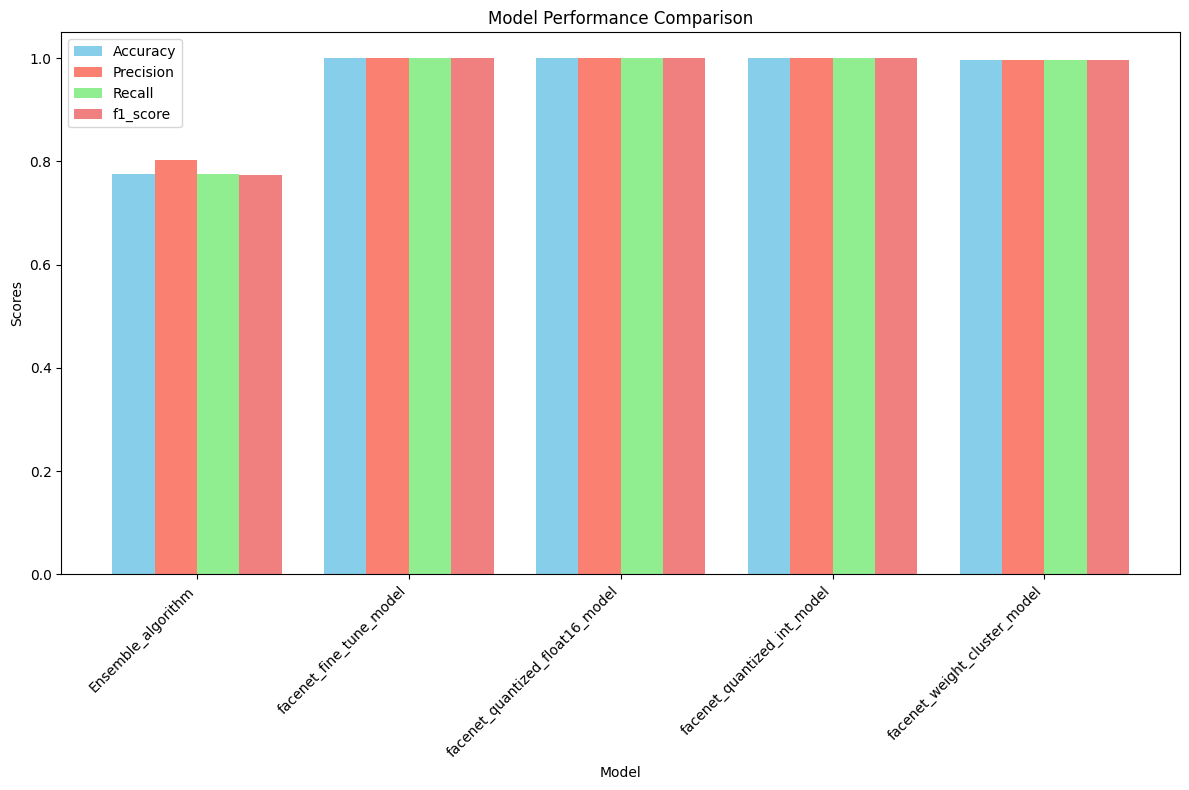

In [103]:
accuracy_scores = accuracy_df.iloc[0, :].values
precision_scores = accuracy_df.iloc[1, :].values
recall_scores = accuracy_df.iloc[2, :].values
f1_scores = accuracy_df.iloc[3, :].values

# Create a DataFrame with the provided data
data = {
    'Model': ['Ensemble_algorithm', 'facenet_fine_tune_model', 'facenet_quantized_float16_model',
              'facenet_quantized_int_model', 'facenet_weight_cluster_model'],
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'f1_score': f1_scores
}

df = pd.DataFrame(data)

# Set the size of the figure
plt.figure(figsize=(12, 8))

# Define the metrics and colors for the bars
metrics = ['Accuracy', 'Precision', 'Recall', 'f1_score']
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral']

# Number of models
n_models = len(df['Model'])

# Position of each bar
bar_width = 0.2  # Width of each bar
index = np.arange(n_models)  # The label locations

# Plot each metric as a separate set of bars
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, df[metric], width=bar_width, color=colors[i], label=metric)

# Set the title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Scores')

# Set x-ticks to the center of grouped bars
plt.xticks(index + bar_width * 1.5, df['Model'], rotation=45, ha='right')

# Add a legend to differentiate the metrics
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

### Compare the compression rate of differen models

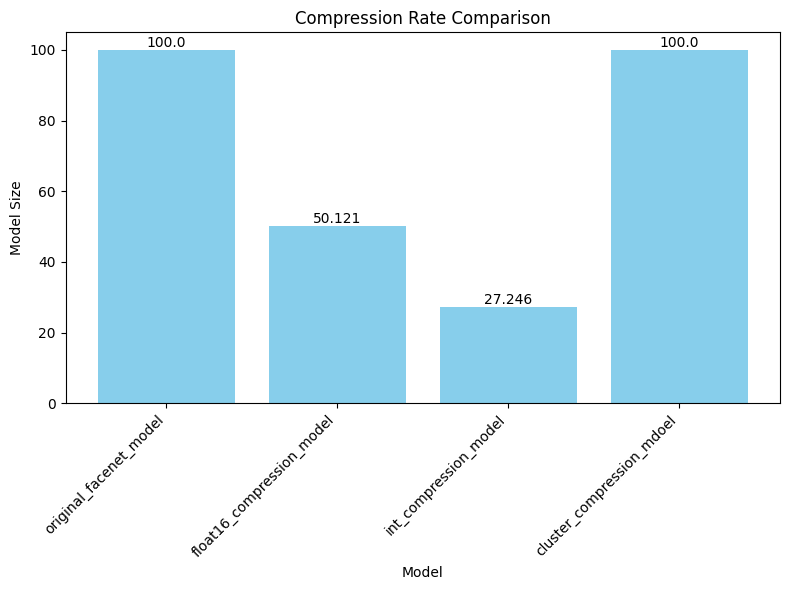

In [118]:
compression_titles = ['original_facenet_model', 'float16_compression_model', 'int_compression_model', 'cluster_compression_mdoel']
compression_rate_values = [100, float_compression_rate, int_compression_rate, cluster_model_compression_rate]

# set figure size
plt.figure(figsize=(8, 6))

# plot bar graph
bars = plt.bar(compression_titles, compression_rate_values, color='skyblue')

# set title and label
plt.title('Compression Rate Comparison')
plt.xlabel('Model')
plt.ylabel('Model Size')

# add text on the top of each bar
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + (bar.get_width() / 2), height, f'{height}', ha='center', va='bottom')

# rotate x to avoid overlapping
plt.xticks(rotation=45, ha='right')

# display graph
plt.tight_layout()
plt.show()

### Compare space saving rate if differen models

In [105]:
def get_gzipped_model_size(file):
    # It returns the size of the gzipped model in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [106]:
space_saving_titles = ['original_facenet_model', 'float16_model', 'int_model', 'cluster_mdoel']
space_saving_files = [tflite_model_file, tflite_model_fp16_file, tflite_model_int_file, tflite_cluster_model_file]
saving_rate_calculator = lambda ori, quant: round((ori - quant) / ori, 2)
ori_size = get_gzipped_model_size(tflite_model_file)
space_saving_rate_values = [saving_rate_calculator(ori_size, ori_size)]

for tflite_path in space_saving_files[1:]:
    tflite_model_size = get_gzipped_model_size(tflite_path)
    space_saving_rate_values.append(saving_rate_calculator(ori_size, tflite_model_size))

In [115]:
space_saving_rate_values

[0.0, 0.5, 0.75, 0.85]

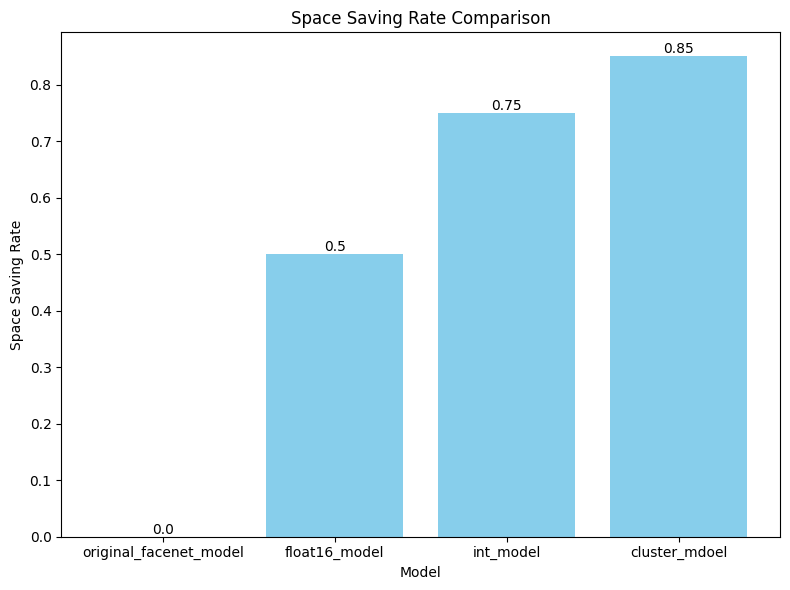

In [116]:
space_saving_titles = ['original_facenet_model', 'float16_model', 'int_model', 'cluster_mdoel']
space_saving_rate_values = [0.0, 0.5, 0.75, 0.85]

# set figure size
plt.figure(figsize=(8, 6))

# plot bar graph
bars = plt.bar(space_saving_titles, space_saving_rate_values, color='skyblue')

# set title and label
plt.title('Space Saving Rate Comparison')
plt.xlabel('Model')
plt.ylabel('Space Saving Rate')

# add text on the top of each bar
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + (bar.get_width() / 2), height, f'{height}', ha='center', va='bottom')

# display graph
plt.tight_layout()
plt.show()

### Compare the face verification before/after model fine-tune

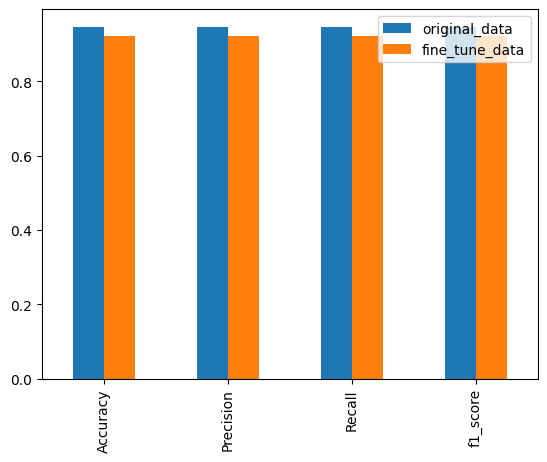

In [108]:
pd.DataFrame({'original_data': original_facenet_test_results, 
              'fine_tune_data': facenet_fine_tune_verification_test_results}).plot.bar();

# Project testing

In [1]:
from face_recognition_testing import main

In [3]:
main(rounds=50)

real label: Vladimir_Putin | prediction:  Vladimir_Putin
real label: Recep_Tayyip_Erdogan | prediction:  Recep_Tayyip_Erdogan
real label: John_Negroponte | prediction:  John_Negroponte
real label: Vicente_Fox | prediction:  Vicente_Fox
real label: Roh_Moo-hyun | prediction:  Roh_Moo-hyun
real label: Colin_Powell | prediction:  Colin_Powell
real label: George_W_Bush | prediction:  George_W_Bush
real label: Ariel_Sharon | prediction:  Ariel_Sharon
real label: Hans_Blix | prediction:  Hans_Blix
real label: Roh_Moo-hyun | prediction:  Roh_Moo-hyun
real label: Megawati_Sukarnoputri | prediction:  Megawati_Sukarnoputri
real label: Megawati_Sukarnoputri | prediction:  Megawati_Sukarnoputri
real label: Jean_Chretien | prediction:  Jean_Chretien
real label: Serena_Williams | prediction:  Serena_Williams
real label: Laura_Bush | prediction:  Laura_Bush
real label: Arnold_Schwarzenegger | prediction:  Arnold_Schwarzenegger
real label: Colin_Powell | prediction:  Colin_Powell
real label: Ariel_Sha